## Data processing and Feature Selection 

We will handle the incorrect values for some features and encoding a categorical features, as well as the preparation of data by reducing and selecting the best features.

**Note**:

In a real machine learning model project (for production), the data processing will be done separately in the training data, and then we will applied the same transformation to the test data. In this project, I will be applying some data processing in the whole data (before splitting the data) with the aim of simplifying the workflow.

### Data processing and feature selection life cycle

#### 1. Convert feature names to lowercase and Remove irrelevant variable
#### 2. Encoding / Transform / Correct values in the features of the object type
$\;\;$ 2.1 Encoding "ur" feature<br>
$\;\;$ 2.2 Encoding "metromicro" and "iecc_climate_pub" features<br> 
$\;\;$ 2.3 Correct "nocrcash" and "nkrgalnc" features<br> 
#### 3. Feature Extraction / Selection
$\;\;$ 3.1 Discover the importance of features<br>
$\;\;\;\;\;$ 3.1.1 Divide data (train/test)<br>
$\;\;\;\;\;$ 3.1.2 ExtraTreesRegressor for the important features<br>
$\;\;$ 3.2 Principal Component Analysis "PCA"<br>
$\;\;\;\;\;$ 3.2.1 Create a new dataframe for Training set (PCA)<br>
$\;\;\;\;\;$ 3.2.2 Save the train data in a csv file<br>
$\;\;\;\;\;$ 3.2.3 Create a new dataframe for Test set (PCA)<br>
$\;\;\;\;\;$ 3.2.4 Save the test data in a csv file<br>
#### 4. Conclusion

In [1]:
# Importing the libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load the RECS dataset
path = "data/"
df = pd.read_csv(path+'recs2009_public.csv')
df.head()

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEKER,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,...,-2,4A,2117,56,4250,0.48,6,56,9,96
1,2,4,10,26,2,8599.17,2662,199,2688,143,...,-2,3C,62,26,2393,0.61,0,64,38,73
2,3,1,1,1,5,8969.92,6233,505,5741,829,...,-2,5A,2346,49,5654,0.48,3,52,12,88
3,4,2,3,7,2,18003.64,6034,672,5781,868,...,-2,5A,2746,0,4941,0.55,4,55,7,87
4,5,1,1,1,3,5999.61,5388,702,5313,797,...,-2,5A,2251,0,5426,0.61,4,50,13,90


## 1. Convert feature names to lowercase and Remove irrelevant variable

We can see that the names of the descriptors are not consistent

In [3]:
# Convert all column headers (feature names) to lowercase
nettoyage_colonnes_noms = []
colonnes = df.columns
for i in range(len(colonnes)):
    nettoyage_colonnes_noms.append(colonnes[i].lower())
df.columns = nettoyage_colonnes_noms
df.head(2)

,doeid,regionc,division,reportable_domain,typehuq,nweight,hdd65,cdd65,hdd30yr,cdd30yr,...,scaleker,iecc_climate_pub,hdd50,cdd80,gnd_hdd65,wsf,oa_lat,gwt,designdbt99,designdbt1
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,...,-2,4A,2117,56,4250,0.48,6,56,9,96
1,2,4,10,26,2,8599.17,2662,199,2688,143,...,-2,3C,62,26,2393,0.61,0,64,38,73


As we can see, the values of the **doeid** variable are unique identifiers for each customer. I will remove it from the dataframe, as they do not give useful information for ML model.

In [4]:
# Remove irrelevant variable as shown above
df = df.drop(["doeid"], axis = 1)

## 2. Encoding / Transform / Correct values in the features of the object type

In [5]:
# Analyze the categorical_object_features
categorical_object_features = [feature for feature in df.columns if df[feature].dtype == 'O']
categorical_object_features

['metromicro', 'ur', 'nocrcash', 'nkrgalnc', 'iecc_climate_pub']

### 2.1 Encoding "ur" feature

In [6]:
# Unique values of 'ur'
df["ur"].value_counts()

U    9656
R    2427
Name: ur, dtype: int64

We only have 2 categories (**U** or **R**), in this case we choose a simple encoding with mapping method

In [7]:
# Encoding with mapping
map_sex = {"U": 1, "R": 0}
df['ur_encode'] = df.ur.map(map_sex)
# Drop ur feature
df.drop('ur', axis=1, inplace=True)
df['ur_encode'].value_counts()

1    9656
0    2427
Name: ur_encode, dtype: int64

### 2.2 Encoding "metromicro" and "iecc_climate_pub" features

The solution to deal with categorical variables (**metromicro** and **iecc_climate_pub**) with more than two categories is to use **one-hot encoding** method.

In [8]:
# Preparation for data encoding
# X has the data of the two features "metromicro", "iecc_climate_pub"
X = df[["metromicro", "iecc_climate_pub"]]
# Create a categorical boolean mask
categorical_feature_mask = X.dtypes == object
# Filter categorical columns in a list
categorical_cols = X.columns[categorical_feature_mask].tolist()

In [9]:
from sklearn.preprocessing import OneHotEncoder

# Instantiate the OneHotEncoder object
ohe = OneHotEncoder(handle_unknown='ignore', sparse = False)

# Apply ohe on the data
ohe.fit(X[categorical_cols])
cat_ohe = ohe.transform(df[categorical_cols])

In [10]:
# Create a hot encoded column DataFrame
df_ohe = pd.DataFrame(cat_ohe, columns = ohe.get_feature_names(input_features = categorical_cols))

# Concat with original df and remove original columns "metromicro" and "iecc_climate_pub"
df = pd.concat([df, df_ohe], axis=1).drop(columns = categorical_cols, axis=1)

In [11]:
df.head()

,regionc,division,reportable_domain,typehuq,nweight,hdd65,cdd65,hdd30yr,cdd30yr,climate_region_pub,...,iecc_climate_pub_2B,iecc_climate_pub_3A,iecc_climate_pub_3B-4B,iecc_climate_pub_3C,iecc_climate_pub_4A,iecc_climate_pub_4C,iecc_climate_pub_5A,iecc_climate_pub_5B-5C,iecc_climate_pub_6A-6B,iecc_climate_pub_7A-7B-7AK-8AK
0,2,4,12,2,2471.68,4742,1080,4953,1271,4,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,4,10,26,2,8599.17,2662,199,2688,143,5,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,1,5,8969.92,6233,505,5741,829,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2,3,7,2,18003.64,6034,672,5781,868,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,1,1,3,5999.61,5388,702,5313,797,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### 2.3 Correct "nocrcash" and "nkrgalnc" features

As the values are categorical, and we have only two values "**.**" in each feature , we propose to replace these "**.**" values by the most frequent values in  nocrcash and nkrgalnc. Then convert the type of each feature to integer.

#### "nocrcash" feature

In [13]:
# Unique values of 'nocrcash'
df["nocrcash"].value_counts()

-2    9958
-2    2028
1       18
3       10
4       10
5        9
2        7
1        6
16       4
6        3
12       3
8        3
3        2
12       2
15       2
24       2
55       2
4        2
.        2
10       1
20       1
25       1
55       1
40       1
10       1
20       1
24       1
6        1
28       1
Name: nocrcash, dtype: int64

In [14]:
# Replace "." by most frequent values and convert the type of feature to integer.
mode_value = df["nocrcash"].mode()[0]
df["nocrcash"] = df["nocrcash"].replace('.', mode_value).astype(int)
df["nocrcash"].value_counts()

-2     11988
 1        24
 3        12
 4        12
 5         9
 2         7
 12        5
 6         4
 16        4
 24        3
 55        3
 8         3
 10        2
 15        2
 20        2
 25        1
 40        1
 28        1
Name: nocrcash, dtype: int64

#### "nkrgalnc" feature

In [15]:
# Unique values of 'nocrcash'
df["nkrgalnc"].value_counts()

-2    9958
-2    2028
5       42
3       11
1       10
10       8
5        5
10       5
.        2
15       2
1        2
77       1
3        1
8        1
30       1
20       1
15       1
8        1
2        1
2        1
55       1
Name: nkrgalnc, dtype: int64

In [16]:
# Replace "." by most frequent values and convert the type of feature to integer.
mode_value = df["nkrgalnc"].mode()[0]
df["nkrgalnc"] = df["nkrgalnc"].replace('.', mode_value).astype(int)
df["nkrgalnc"].value_counts()

-2     11988
 5        47
 10       13
 3        12
 1        12
 15        3
 2         2
 8         2
 55        1
 30        1
 77        1
 20        1
Name: nkrgalnc, dtype: int64

## 3. Feature Extraction / Selection

Having too many irrelevant features in the data can decrease the accuracy of the models. Three benefits of performing feature selection before modeling our data are:
* Reduces over-fitting: Less redundant data means less opportunity to make decisions based on noise.
* Improves accuracy: Less misleading data means modeling accuracy improves.
* Reduces training time: Less data means that algorithms train faster.

### 3.1 Discover the importance of features

In order to get a rough idea about the important features, we apply the **ExtraTreesRegressor** to find out the important characteristics for our target.

**Why ExtraTreesRegressor ?** <br>
ExtraTreesRegressor is about building multiple decision trees. Decision tree doesn't require feature normalization, that's because the model only needs the absolute values for branching.

### 3.1.1.  Divide data (train/test)

In [17]:
from sklearn.model_selection import train_test_split

#Splitting the dataset into training data and test data
X = df.drop(columns = ["kwh"], axis=1)
y = df.kwh
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

The code above splits the database.

We will use 80 $ \% $ of the data for the training process, then, we will use the remaining 20 $ \% $ to test our model.

### 3.1.2. ExtraTreesRegressor for the important features

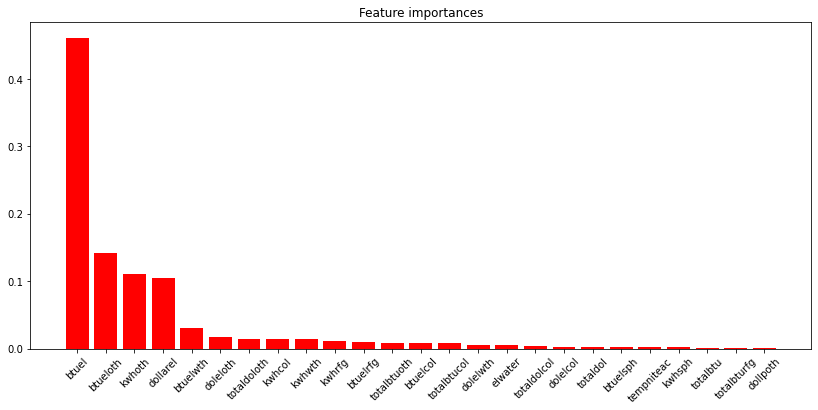

In [18]:
from sklearn.ensemble import ExtraTreesRegressor

# Create a ExtraTreesRegressor
model_extra_tree = ExtraTreesRegressor()

# Fit model on the train set
model_extra_tree.fit(X_train,y_train)

indices_extra_tree = np.argsort(model_extra_tree.feature_importances_)[::-1]
selected_feature_extra_tree = []

# Select the best 25 features
for i in range(25):
    selected_feature_extra_tree.append(X_train.columns[indices_extra_tree[i]])
    
# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(14,6))
plt.title("Feature importances")
plt.bar(selected_feature_extra_tree, model_extra_tree.feature_importances_[indices_extra_tree[range(25)]],
        color="r", align="center")
plt.xticks(rotation=45)
plt.show()

This examples shows the use of ExtraTreesRegressor to evaluate the importance of features. The red bars are the impurity-based feature importances of the forest, along with their inter-trees variability.

As expected, the plot suggests that **4** features are informative ['btuel', 'btueloth', 'kwhoth', 'dollarel'], while the remaining 21 features are less informative.

**Note !**:

The problem that the most informative features are strongly correlated such as "btuel" with "btueloth" (Correlation= 88), the solution is to use **PCA** to reduce dimensionality and deal with highly correlated variables.

### 3.2. Principal Component Analysis "PCA"

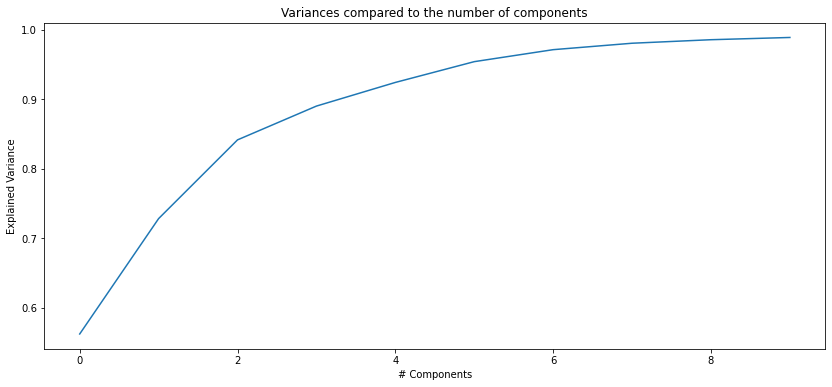

In [55]:
from sklearn.decomposition import PCA

# Initiate PCA
pca = PCA(n_components=10)

# Transform and fit PCA
pca.fit(X_train)
pca.transform(X_train)

# Display the graph that allows us to see the variances explained in relation to the number of components
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(14,6))
plt.title('Variances compared to the number of components')
plt.ylabel('Explained Variance')
plt.xlabel('# Components')
plt.plot(exp_var_cumul)
plt.show()

In [56]:
print(np.round(exp_var_cumul, 3))

[0.563 0.728 0.842 0.89  0.924 0.954 0.971 0.981 0.986 0.989]


In [27]:
variance_explique = pca.explained_variance_ratio_
print(variance_explique)

[0.56255486 0.16593074 0.11321839 0.04859468 0.03400167 0.02988174
 0.01723562 0.00925296 0.00506752 0.00323339]


In [28]:
# Display PCA components
print(pca.components_)

[[-3.67770819e-06 -9.47296405e-06 -3.09335456e-05 ...  1.29169296e-07
   5.04176816e-07  5.20818823e-08]
 [-2.21529518e-06 -7.89579112e-06 -1.68819046e-05 ... -2.21620914e-07
   1.57286896e-07  1.00040296e-07]
 [-1.03188449e-05 -2.43115333e-05 -8.22258023e-05 ... -3.26086886e-08
   1.16542570e-06  2.49451288e-07]
 ...
 [ 7.89427166e-06  1.42034694e-05  8.08965915e-05 ... -2.25389066e-06
  -3.31939111e-06 -7.55165833e-07]
 [-9.40207499e-06 -3.18990935e-05 -8.04992201e-05 ... -3.86073587e-07
  -3.45120555e-07  6.08664552e-07]
 [ 9.19312178e-06  2.84220472e-05  7.72994661e-05 ...  3.87926062e-08
   6.40224245e-07  1.89795081e-07]]


After implementing the PCA on training dataset, all the Principal Components are independent of one another. There is no correlation among them.

**Select the number of principal components "k"?**

Based on this **graph** and **exp_var_cumul**, we can decide how many principal components we need to take into account.

To keep **99% of the variance**, We choose **k = 10** as number of principal components.

### 3.2.1. Create a new dataframe for Training set (PCA)

In [57]:
# Create a new Dataframe for training set (for the 10 principal components with target)
X_train_reindex = X_train.reset_index(drop=True)
principalComponents_train = pca.transform(X_train_reindex)
principalDf = pd.DataFrame(data = principalComponents_train
             , columns = ['principal component 1', 'principal component 2', 'principal component 3',
                         'principal component 4', 'principal component 5', 'principal component 6',
                         'principal component 7', 'principal component 8', 'principal component 9',
                         'principal component 10'])

# Concatenating DataFrame along axis = 1. final_df_train is the final DataFrame of training set
y_train_reindex = y_train.reset_index(drop=True)
final_df_train = pd.concat([principalDf, y_train_reindex], axis = 1)
final_df_train.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,kwh
0,64443.196746,-12130.552231,-9017.046877,-1576.906272,-3944.797021,-6800.028513,-6447.942944,-5941.548058,-9249.646039,3445.806410,12457
1,33174.440448,-28476.093839,1765.176862,-700.302650,-467.458937,3454.452037,3303.774092,-5001.737759,-3809.080620,1257.522820,7460
2,-89626.023751,-15250.684842,355.415866,-4.331309,-3812.731708,293.242956,4627.438961,-5422.789170,-3029.805489,134.897706,8048
3,125195.396039,-52763.690651,17210.150361,5276.678821,630.407621,-501.823369,-1494.136485,-328.965622,2114.788736,-1933.006179,4510
4,7884.987330,77318.319389,-5588.448482,91911.471228,16125.491252,40596.859494,-14983.005210,2822.441916,-13386.277300,-29635.386235,13062


### 3.2.2. Save the data train in a csv file

In [58]:
# Save the data train in a csv file
path = "data/"
final_df_train.to_csv(path+"df_train_out.csv")

### 3.2.3. Create a new dataframe for Test set (PCA)

In [63]:
# Create a new Dataframe for test set (for the 10 principal components with target)
X_test_reindex = X_test.reset_index(drop=True)
principalComponents_test = pca.transform(X_test_reindex)
principalDf_test = pd.DataFrame(data = principalComponents_test
             , columns = ['principal component 1', 'principal component 2', 'principal component 3',
                         'principal component 4', 'principal component 5', 'principal component 6',
                         'principal component 7', 'principal component 8', 'principal component 9',
                         'principal component 10'])

# Concatenating DataFrame along axis = 1. final_df_test is the final DataFrame of test set
y_test_reindex = y_test.reset_index(drop=True)
final_df_test = pd.concat([principalDf_test, y_test_reindex], axis = 1)
final_df_test.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,kwh
0,-7082.624158,62806.677344,3426.098071,88687.495260,34433.722502,23025.490116,-2913.322464,-3329.052389,-6280.628412,-5982.627884,11486
1,-81250.244342,-5418.177198,-2675.934767,1010.675723,3951.845636,-6329.488403,2745.819163,-4616.033222,2283.915194,1309.382732,10604
2,45321.211106,-2552.171582,-17824.864791,-7841.476108,-4357.864113,4400.598150,-16385.720246,2116.096809,-1899.301756,2107.390593,14658
3,-67272.414637,-9063.048115,-6640.376818,-4384.200719,-3080.645749,7473.793494,2019.241854,-2538.368979,-1678.640705,3501.380117,9555
4,-68284.463582,12600.520907,-16477.496071,-2680.738177,-9229.079695,-8620.936201,-1783.415529,3221.275685,4855.357096,-1609.298970,15845


In [64]:
final_df_test.isnull().sum()

principal component 1     0
principal component 2     0
principal component 3     0
principal component 4     0
principal component 5     0
principal component 6     0
principal component 7     0
principal component 8     0
principal component 9     0
principal component 10    0
kwh                       0
dtype: int64

### 3.2.4. Save the data test in a csv file

In [65]:
# Save the data test in a csv file
path = "data/"
final_df_test.to_csv(path+"df_test_out.csv")

# 4. Conclusion

In this notebook, we have dealt with the incorrect values of two features and we have applied OneHotEncoder to the categorical features, as well as, discovering the importance of features by using ExtraTreesRegressor method. In addition, we applied the PCA method to reduce the dimensionality and deal with highly correlated variables. At the end, a cleaned train and test data is saved as csv files for the development of ML models.